/home/sim/Dataset/rPPG/PURE/01-01/01-01 /home/sim/Dataset/rPPG/PURE/01-01/01-01.json {'dataset': 'PURE', 'model': 'PhysNet', 'videodataDIR': '/home/sim/Dataset/rPPG/PURE/01-01/01-01', 'signalpath': '/home/sim/Dataset/rPPG/PURE/01-01/01-01.json', 'learning_rate': '1e-3', 'depth': '32', 'height': '128', 'width': '128', 'crop': 'True', 'overlap': '0.75', 'batch_size': '32'}
overlap: 0.75
batch_size: 32
Using cpu device
Epoch 1
-------------------------------
loss: 1.340224  [    0/  197]
loss: 1.092166  [   32/  197]
loss: 1.132473  [   64/  197]
loss: 0.837807  [   96/  197]
loss: 0.944323  [  128/  197]
loss: 0.848368  [  160/  197]
loss: 0.707625  [   30/  197]
Test loss: 1.276242 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


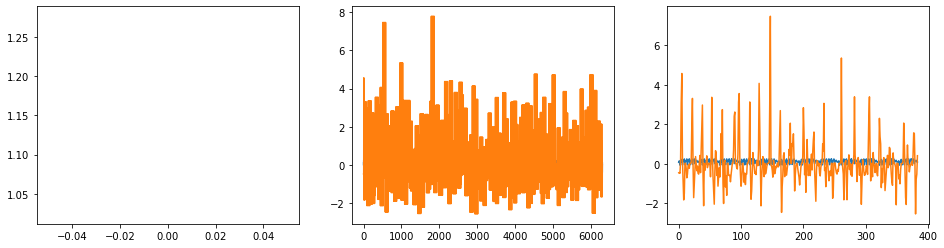

Epoch 2
-------------------------------
loss: 1.378982  [    0/  197]
loss: 1.017886  [   32/  197]
loss: 1.091504  [   64/  197]
loss: 0.826570  [   96/  197]
loss: 0.938346  [  128/  197]
loss: 0.856948  [  160/  197]
loss: 0.723099  [   30/  197]
Test loss: 1.324782 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


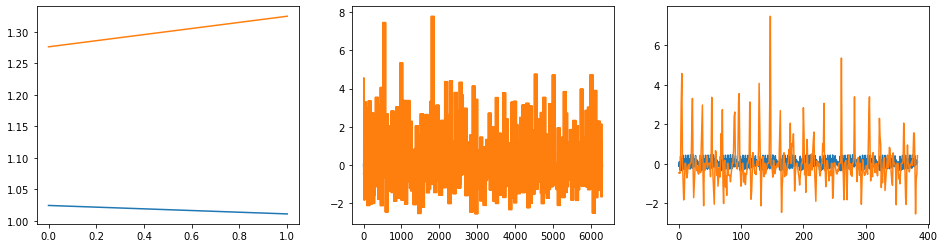

Epoch 3
-------------------------------


KeyboardInterrupt: 

In [2]:
import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from src.dset import DatasetPhysNetED
from src.archs import PhysNetED

import numpy as np
import configparser
import os
import json
import cv2
import matplotlib.pyplot as plt
from skimage import data, io, filters
from tqdm import tqdm

def train_loop(trainloader, model, loss_fn, optimizer):
    model.train()
    size = len(trainloader.dataset)
    train_preds = np.empty(0)
    train_targets = np.empty(0)

    for batch, (inputs, targets) in enumerate(trainloader):
        inputs = inputs.to(device)
        targets = targets.to(device).squeeze()
        pred = model(inputs).squeeze()

        for cnt, pr in enumerate(pred):
            if (batch_size*batch+cnt)%(int(1/overlap)) == 0:
                p = pr.cpu().detach().numpy().squeeze().flatten()
                t = targets[cnt].cpu().detach().numpy().squeeze().flatten()
                train_preds = np.concatenate((train_preds,p))
                train_targets = np.concatenate((train_targets,t))
                
        loss = loss_fn(pred, targets)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1 == 0:
            loss, current = loss.item(), batch * len(targets)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    return train_preds, train_targets
    
def test_loop(testloader, model, loss_fn):
    size = len(testloader.dataset)
    model.eval()    
    test_loss, correct = 0, 0
    test_preds = np.empty(0)
    test_targets = np.empty(0)

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs = inputs.to(device)
            pred = model(inputs).squeeze()
            
            p = pred.cpu().detach().numpy().squeeze().flatten()
            t = targets.cpu().detach().numpy().squeeze().flatten()
            test_preds = np.concatenate((test_preds,p))
            test_targets = np.concatenate((test_targets,t))
        
    return test_preds, test_targets

# if __name__ == '__main__':

configFilename = './config/PURE_PhysNet.cfg'

parser = configparser.ConfigParser(inline_comment_prefixes=('#', ';'))
parser.optionxform = str
parser.read(configFilename)

cfgdict = dict(parser['DEFAULT'].items())
vdir, sigdir = cfgdict['videodataDIR'], cfgdict['signalpath']
print(vdir, sigdir, cfgdict)

# overlap = int(cfgdict['overlap'])
# batch_size = int(cfgdict['batch_size'])
overlap = 0.75
batch_size = 32

print(f'overlap: {overlap}')
print(f'batch_size: {batch_size}')

trainset = DatasetPhysNetED(cfgdict, start = 0, end = 1600, overlap = overlap)
testset = DatasetPhysNetED(cfgdict, start = 1601, end = 2009, overlap = 0)

# Construct DataLoaders
trainloader = DataLoader(trainset,
                        batch_size = batch_size)
testloader = DataLoader(testset,
                        batch_size = batch_size)

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Load Model
model = PhysNetED()
if device != 'cpu':
    model = model.cuda()
loss_fn = nn.MSELoss()
learning_rate = float(cfgdict['learning_rate'])
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate)


# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('logs/fashion_mnist_experiment_1')

model_name = 'PhysNet_v7'

if not os.path.exists('checkpoints'):
    os.mkdir('checkpoints')
if not os.path.exists('checkpoints/'+model_name):
    os.mkdir('checkpoints/'+model_name)


epochs = 100
train_losses = []
test_losses = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")

    train_preds, train_targets = train_loop(trainloader, model, loss_fn, optimizer)
    test_preds, test_targets = test_loop(testloader, model, loss_fn)

    torch.save(model.state_dict(), 'checkpoints/'+model_name +f'/model_ep{epoch}.pth')

    train_loss = loss_fn(torch.Tensor(train_preds), torch.Tensor(train_targets))
    train_loss = train_loss.cpu().detach().numpy().squeeze()

    test_loss = loss_fn(torch.Tensor(test_preds), torch.Tensor(test_targets))
    test_loss = test_loss.cpu().detach().numpy().squeeze()
    print(f"Test loss: {test_loss:>8f} \n")

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    np.save(model_name+'_loss',(train_preds, train_targets, test_preds, test_targets))

    plt.figure(figsize=[16,4])
    plt.subplot(131)
    plt.plot(train_losses)
    plt.plot(test_losses)

    plt.subplot(132)
    plt.plot(train_preds)
    plt.plot(train_targets)

    plt.subplot(133)
    plt.plot(test_preds)
    plt.plot(test_targets)
    plt.show()
print("Done!")



In [1]:
import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from src.dset import DatasetPhysNetED
from src.archs import PhysNetED

import numpy as np
import configparser
import os
import json
import cv2
import matplotlib.pyplot as plt
from skimage import data, io, filters
from tqdm import tqdm

def train_loop(trainloader, model, loss_fn, optimizer):
    model.train()
    size = len(trainloader.dataset)
    train_preds = np.empty(0)
    train_targets = np.empty(0)

    for batch, (inputs, targets) in enumerate(trainloader):
        inputs = inputs.to(device)
        targets = targets.to(device).squeeze()
        pred = model(inputs).squeeze()

        for cnt, pr in enumerate(pred):
            if (batch_size*batch+cnt)%(int(1/overlap)) == 0:
                p = pr.cpu().detach().numpy().squeeze().flatten()
                t = targets[cnt].cpu().detach().numpy().squeeze().flatten()
                train_preds = np.concatenate((train_preds,p))
                train_targets = np.concatenate((train_targets,t))
                
        loss = loss_fn(pred, targets)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1 == 0:
            loss, current = loss.item(), batch * len(targets)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    return train_preds, train_targets
    
def test_loop(testloader, model, loss_fn):
    size = len(testloader.dataset)
    model.eval()    
    test_loss, correct = 0, 0
    test_preds = np.empty(0)
    test_targets = np.empty(0)

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs = inputs.to(device)
            pred = model(inputs).squeeze()
            
            p = pred.cpu().detach().numpy().squeeze().flatten()
            t = targets.cpu().detach().numpy().squeeze().flatten()
            test_preds = np.concatenate((test_preds,p))
            test_targets = np.concatenate((test_targets,t))
        
    return test_preds, test_targets

# if __name__ == '__main__':

configFilename = './config/PURE_PhysNet.cfg'

parser = configparser.ConfigParser(inline_comment_prefixes=('#', ';'))
parser.optionxform = str
parser.read(configFilename)

cfgdict = dict(parser['DEFAULT'].items())
vdir, sigdir = cfgdict['videodataDIR'], cfgdict['signalpath']
print(vdir, sigdir, cfgdict)

# overlap = int(cfgdict['overlap'])
# batch_size = int(cfgdict['batch_size'])
overlap = 0.75
batch_size = 32

print(f'overlap: {overlap}')
print(f'batch_size: {batch_size}')

trainset = DatasetPhysNetED(cfgdict, start = 0, end = 1600, overlap = overlap)
testset = DatasetPhysNetED(cfgdict, start = 1601, end = 2009, overlap = 0)

# Construct DataLoaders
trainloader = DataLoader(trainset,
                        batch_size = batch_size)
testloader = DataLoader(testset,
                        batch_size = batch_size)

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Load Model
model = PhysNetED()
if device != 'cpu':
    model = model.cuda()
loss_fn = nn.MSELoss()
learning_rate = float(cfgdict['learning_rate'])
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate)


# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('logs/fashion_mnist_experiment_1')

model_name = 'PhysNet_v7'

if not os.path.exists('checkpoints'):
    os.mkdir('checkpoints')
if not os.path.exists('checkpoints/'+model_name):
    os.mkdir('checkpoints/'+model_name)


epochs = 100
train_losses = []
test_losses = []


/home/sim/Dataset/rPPG/PURE/01-01/01-01 /home/sim/Dataset/rPPG/PURE/01-01/01-01.json {'dataset': 'PURE', 'model': 'PhysNet', 'videodataDIR': '/home/sim/Dataset/rPPG/PURE/01-01/01-01', 'signalpath': '/home/sim/Dataset/rPPG/PURE/01-01/01-01.json', 'learning_rate': '1e-3', 'depth': '32', 'height': '128', 'width': '128', 'crop': 'True', 'overlap': '0.75', 'batch_size': '32'}
overlap: 0.75
batch_size: 32
Using cpu device


/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554800319/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")

    train_preds, train_targets = train_loop(trainloader, model, loss_fn, optimizer)
    test_preds, test_targets = test_loop(testloader, model, loss_fn)

    torch.save(model.state_dict(), 'checkpoints/'+model_name +f'/model_ep{epoch}.pth')

    train_loss = loss_fn(torch.Tensor(train_preds), torch.Tensor(train_targets))
    train_loss = train_loss.cpu().detach().numpy().squeeze()

    test_loss = loss_fn(torch.Tensor(test_preds), torch.Tensor(test_targets))
    test_loss = test_loss.cpu().detach().numpy().squeeze()
    print(f"Test loss: {test_loss:>8f} \n")

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    np.save(model_name+'_loss',(train_preds, train_targets, test_preds, test_targets))

    plt.figure(figsize=[16,4])
    plt.subplot(131)
    plt.plot(train_losses)
    plt.plot(test_losses)

    plt.subplot(132)
    plt.plot(train_preds)
    plt.plot(train_targets)

    plt.subplot(133)
    plt.plot(test_preds)
    plt.plot(test_targets)
    plt.show()
print("Done!")

